In [1]:
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf

In [2]:
# Read in csv file
df = pd.read_csv('GPTarget2024.csv')

In [3]:
# Create new dataframes split by issue
df_digital_privacy = df[df['issue_stance'] == "The U.S. should not implement legislation that strengthens digital privacy rights"]
df_renewable_energy = df[df['issue_stance'] == "The U.S. should increase investments in renewable energy technologies."]
df_china_sanctions = df[df['issue_stance'] == "The U.S. should impose stronger economic sanctions on China."]
df_nato_support = df[df['issue_stance'] == "The U.S. should not increase its support for NATO."]

In [4]:
# Split by age groups
df_under_27 = df[df['age'] < 27]
df_28_45 = df[(df['age'] >= 27) & (df['age'] <= 45)]
df_46_plus = df[df['age'] > 45]

df_digital_privacy_under_27 = df_digital_privacy[df_digital_privacy['age'] < 27]
df_digital_privacy_28_45 = df_digital_privacy[(df_digital_privacy['age'] >= 27) & (df_digital_privacy['age'] <= 45)]
df_digital_privacy_46_plus = df_digital_privacy[df_digital_privacy['age'] > 45]

df_renewable_energy_under_27 = df_renewable_energy[df_renewable_energy['age'] < 27]
df_renewable_energy_28_45 = df_renewable_energy[(df_renewable_energy['age'] >= 27) & (df_renewable_energy['age'] <= 45)]
df_renewable_energy_46_plus = df_renewable_energy[df_renewable_energy['age'] > 45]

df_china_sanctions_under_27 = df_china_sanctions[df_china_sanctions['age'] < 27]
df_china_sanctions_28_45 = df_china_sanctions[(df_china_sanctions['age'] >= 27) & (df_china_sanctions['age'] <= 45)]
df_china_sanctions_46_plus = df_china_sanctions[df_china_sanctions['age'] > 45]

df_nato_support_under_27 = df_nato_support[df_nato_support['age'] < 27]
df_nato_support_28_45 = df_nato_support[(df_nato_support['age'] >= 27) & (df_nato_support['age'] <= 45)]
df_nato_support_46_plus = df_nato_support[df_nato_support['age'] > 45]


In [5]:
# Define the issues and age groups
issues = ['digital_privacy', 'renewable_energy', 'china_sanctions', 'nato_support']
age_groups = ['under_27', '28_45', '46_plus']

# Dictionary to hold the models and results
models = {}
results = {}

# Loop over each issue and age group to create and fit the models
for issue in issues:
    for age_group in age_groups:
        df_name = f'df_{issue}_{age_group}'
        
        # Access the dataframe from the locals() dictionary
        df = locals()[df_name]
        
        # Define the formula
        formula = 'dv_response_mean ~ Q("microtargeting") + Q("false microtargeting") + Q("no microtargeting") + political_party_coded + political_ideology_coded + political_engagement_coded'
        
        # Create and fit the model
        models[df_name] = smf.ols(formula=formula, data=df)
        results[df_name] = models[df_name].fit()

# Now you can access each result using the results dictionary
# For example, to access the result for digital privacy for under 27:
result_digital_privacy_under_27 = results['df_digital_privacy_under_27']
result_digital_privacy_28_45 = results['df_digital_privacy_28_45']
result_digital_privacy_46_plus = results['df_digital_privacy_46_plus']
result_renewable_energy_under_27 = results['df_renewable_energy_under_27']
result_renewable_energy_28_45 = results['df_renewable_energy_28_45']
result_renewable_energy_46_plus = results['df_renewable_energy_46_plus']
result_china_sanctions_under_27 = results['df_china_sanctions_under_27']
result_china_sanctions_28_45 = results['df_china_sanctions_28_45']
result_china_sanctions_46_plus = results['df_china_sanctions_46_plus']
result_nato_support_under_27 = results['df_nato_support_under_27']
result_nato_support_28_45 = results['df_nato_support_28_45']
result_nato_support_46_plus = results['df_nato_support_46_plus']


In [6]:
# Create a dataframe to store the results for plotting
age_group_models = {
    'Digital Privacy Under 27': results['df_digital_privacy_under_27'],
    'Digital Privacy 28-45': results['df_digital_privacy_28_45'],
    'Digital Privacy 46 Plus': results['df_digital_privacy_46_plus'],
    'Renewable Energy Under 27': results['df_renewable_energy_under_27'],
    'Renewable Energy 28-45': results['df_renewable_energy_28_45'],
    'Renewable Energy 46 Plus': results['df_renewable_energy_46_plus'],
    'China Sanctions Under 27': results['df_china_sanctions_under_27'],
    'China Sanctions 28-45': results['df_china_sanctions_28_45'],
    'China Sanctions 46 Plus': results['df_china_sanctions_46_plus'],
    'NATO Support Under 27': results['df_nato_support_under_27'],
    'NATO Support 28-45': results['df_nato_support_28_45'],
    'NATO Support 46 Plus': results['df_nato_support_46_plus']
}

# Initialize an empty list to store the data
data = []

# Iterate over the dictionary to extract the data
for issue_age_group, model in age_group_models.items():
    # Extract the coefficients and the confidence intervals
    coef = model.params
    conf_int = model.conf_int()
    
    # Determine the age group from the issue_age_group key
    if 'Under 27' in issue_age_group:
        age_group = 'Under 27'
    elif '28-45' in issue_age_group:
        age_group = '28-45'
    else:
        age_group = '46 Plus'
    
    # Iterate over the coefficients
    for covariate in ['microtargeting', 'false microtargeting', 'no microtargeting']:
        # Use the Q function label format
        q_covariate = f'Q("{covariate}")'
        # Skip if the covariate is not in the model
        if q_covariate not in coef:
            continue
        # Get the coefficient and confidence interval
        coefficient = coef[q_covariate]
        lower_ci, upper_ci = conf_int.loc[q_covariate]
        
        # Append the data to the list
        data.append({
            'Covariate': covariate,
            'Issue_Age_Group': issue_age_group.replace(' ', '_'),
            'Age_Group': age_group,
            'Coefficient': coefficient,
            '95% CI Lower': lower_ci,
            '95% CI Upper': upper_ci
        })

# Create a DataFrame from the list
results_df = pd.DataFrame(data)

In [7]:
def compute_weighted_stats(term, models):
    coefficients = np.array([model.params[term] for model in models])
    standard_errors = np.array([model.bse[term] for model in models])

    weights = 1 / standard_errors**2
    weighted_mean = np.sum(coefficients * weights) / np.sum(weights)
    weighted_variance = 1 / np.sum(weights)
    weighted_std_error = np.sqrt(weighted_variance)

    z_critical = scipy.stats.norm.ppf(0.975)  # 97.5th percentile for two-tailed test
    confidence_interval = (weighted_mean - z_critical * weighted_std_error, 
                           weighted_mean + z_critical * weighted_std_error)

    return weighted_mean, confidence_interval

# Separate the models by age groups
under_27_models = [results['df_digital_privacy_under_27'], results['df_renewable_energy_under_27'], results['df_china_sanctions_under_27'], results['df_nato_support_under_27']]
age_28_45_models = [results['df_digital_privacy_28_45'], results['df_renewable_energy_28_45'], results['df_china_sanctions_28_45'], results['df_nato_support_28_45']]
age_46_plus_models = [results['df_digital_privacy_46_plus'], results['df_renewable_energy_46_plus'], results['df_china_sanctions_46_plus'], results['df_nato_support_46_plus']]

# Compute the weighted stats for under 27
microtargeting_mean_under_27, microtargeting_ci_under_27 = compute_weighted_stats('Q("microtargeting")', under_27_models)
false_microtargeting_mean_under_27, false_microtargeting_ci_under_27 = compute_weighted_stats('Q("false microtargeting")', under_27_models)
no_microtargeting_mean_under_27, no_microtargeting_ci_under_27 = compute_weighted_stats('Q("no microtargeting")', under_27_models)

# Compute the weighted stats for age 28-45
microtargeting_mean_28_45, microtargeting_ci_28_45 = compute_weighted_stats('Q("microtargeting")', age_28_45_models)
false_microtargeting_mean_28_45, false_microtargeting_ci_28_45 = compute_weighted_stats('Q("false microtargeting")', age_28_45_models)
no_microtargeting_mean_28_45, no_microtargeting_ci_28_45 = compute_weighted_stats('Q("no microtargeting")', age_28_45_models)

# Compute the weighted stats for age 46 plus
microtargeting_mean_46_plus, microtargeting_ci_46_plus = compute_weighted_stats('Q("microtargeting")', age_46_plus_models)
false_microtargeting_mean_46_plus, false_microtargeting_ci_46_plus = compute_weighted_stats('Q("false microtargeting")', age_46_plus_models)
no_microtargeting_mean_46_plus, no_microtargeting_ci_46_plus = compute_weighted_stats('Q("no microtargeting")', age_46_plus_models)

# Create a list of dictionaries for the new rows, separating by age group
weighted_stats_under_27 = [
    {'Covariate': 'microtargeting', 'Issue': 'Precision-weighted mean (Under 27)', 'Age_Group': 'Under 27', 'Coefficient': microtargeting_mean_under_27, '95% CI Lower': microtargeting_ci_under_27[0], '95% CI Upper': microtargeting_ci_under_27[1]},
    {'Covariate': 'false microtargeting', 'Issue': 'Precision-weighted mean (Under 27)', 'Age_Group': 'Under 27', 'Coefficient': false_microtargeting_mean_under_27, '95% CI Lower': false_microtargeting_ci_under_27[0], '95% CI Upper': false_microtargeting_ci_under_27[1]},
    {'Covariate': 'no microtargeting', 'Issue': 'Precision-weighted mean (Under 27)', 'Age_Group': 'Under 27', 'Coefficient': no_microtargeting_mean_under_27, '95% CI Lower': no_microtargeting_ci_under_27[0], '95% CI Upper': no_microtargeting_ci_under_27[1]}
]

weighted_stats_28_45 = [
    {'Covariate': 'microtargeting', 'Issue': 'Precision-weighted mean (28-45)', 'Age_Group': '28-45', 'Coefficient': microtargeting_mean_28_45, '95% CI Lower': microtargeting_ci_28_45[0], '95% CI Upper': microtargeting_ci_28_45[1]},
    {'Covariate': 'false microtargeting', 'Issue': 'Precision-weighted mean (28-45)', 'Age_Group': '28-45', 'Coefficient': false_microtargeting_mean_28_45, '95% CI Lower': false_microtargeting_ci_28_45[0], '95% CI Upper': false_microtargeting_ci_28_45[1]},
    {'Covariate': 'no microtargeting', 'Issue': 'Precision-weighted mean (28-45)', 'Age_Group': '28-45', 'Coefficient': no_microtargeting_mean_28_45, '95% CI Lower': no_microtargeting_ci_28_45[0], '95% CI Upper': no_microtargeting_ci_28_45[1]}
]

weighted_stats_46_plus = [
    {'Covariate': 'microtargeting', 'Issue': 'Precision-weighted mean (46 Plus)', 'Age_Group': '46 Plus', 'Coefficient': microtargeting_mean_46_plus, '95% CI Lower': microtargeting_ci_46_plus[0], '95% CI Upper': microtargeting_ci_46_plus[1]},
    {'Covariate': 'false microtargeting', 'Issue': 'Precision-weighted mean (46 Plus)', 'Age_Group': '46 Plus', 'Coefficient': false_microtargeting_mean_46_plus, '95% CI Lower': false_microtargeting_ci_46_plus[0], '95% CI Upper': false_microtargeting_ci_46_plus[1]},
    {'Covariate': 'no microtargeting', 'Issue': 'Precision-weighted mean (46 Plus)', 'Age_Group': '46 Plus', 'Coefficient': no_microtargeting_mean_46_plus, '95% CI Lower': no_microtargeting_ci_46_plus[0], '95% CI Upper': no_microtargeting_ci_46_plus[1]}
]

# Convert the lists of dictionaries to DataFrames
weighted_stats_under_27_df = pd.DataFrame(weighted_stats_under_27)
weighted_stats_28_45_df = pd.DataFrame(weighted_stats_28_45)
weighted_stats_46_plus_df = pd.DataFrame(weighted_stats_46_plus)

# Append the new DataFrames to the existing results_df
results_df = pd.concat([results_df, weighted_stats_under_27_df, weighted_stats_28_45_df, weighted_stats_46_plus_df], ignore_index=True)


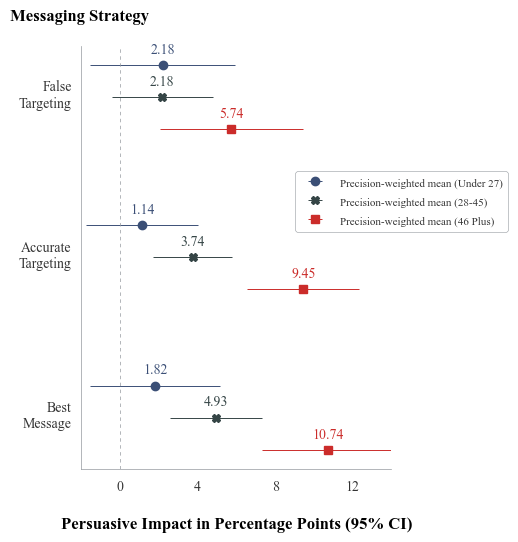

In [8]:
#FIGURE 1 (political party)
# Set the font to "Times New Roman"
plt.rcParams["font.family"] = "Times New Roman"

# Define constants based on results_df
ISSUES = ["Precision-weighted mean (Under 27)", "Precision-weighted mean (28-45)", "Precision-weighted mean (46 Plus)"]
NEW_LABELS = ['no microtargeting', 'microtargeting', 'false microtargeting']
COLOR_MAP = ['#3b4f76', '#354546', '#CB2C2A']
MARKERS = ['o', 'X', 's']

# Set the plot dimensions
fig, ax = plt.subplots(figsize=(4,5.5))

# Initialize y_pos array for the base position of the first issue
base_y_pos = np.arange(len(NEW_LABELS), dtype=float)

# The vertical offset to apply for each subsequent issue
vertical_offset = 0.2  # Adjust as needed for spacing

# Iterate over the unique issues
for idx, (issue, color, marker) in enumerate(zip(ISSUES, COLOR_MAP, MARKERS)):
    # Calculate the y_pos for the current issue with an offset
    y_pos = base_y_pos - idx * vertical_offset
    
    # Filter the results_df for the current issue
    issue_data = results_df[results_df['Issue'] == issue]
    
    # Initialize a variable to control the addition of the label to the legend
    added_label = False
    
    # Set the line width based on the issue
    line_width = 0.7 if issue != "Precision-weighted mean" else 2
    
    # Iterate over the unique covariates
    for i, covariate in enumerate(NEW_LABELS):
        # Filter the issue_data for the current covariate
        covariate_data = issue_data[issue_data['Covariate'] == covariate]
        
        # Plot coefficients with error bars
        ax.errorbar(covariate_data['Coefficient'], y_pos[i], 
                    xerr=[covariate_data['Coefficient'] - covariate_data['95% CI Lower'], 
                          covariate_data['95% CI Upper'] - covariate_data['Coefficient']], 
                    fmt=marker, color=color, ecolor=color, capsize=0, linewidth=line_width,
                    label=issue if not added_label else "")
        
        # Ensure that the label is added only once
        added_label = True
        
        # Add coefficient labels
        ax.text(covariate_data['Coefficient'].values[0], y_pos[i] + 0.1, f"{covariate_data['Coefficient'].values[0]:.2f}", 
                va='center', ha='center', color=color, 
                bbox=dict(facecolor='white', edgecolor='none', pad=2.1))

# Configure the plot
plt.axvline(0, color='#94999E', linestyle='--', linewidth=0.5, dashes=(5, 5))
plt.xlim(-2, 14)

ax.set_xlabel('Persuasive Impact in Percentage Points (95% CI)', fontsize=12, fontweight='bold', labelpad=17)
ax.set_yticks(base_y_pos- 0.17)
ax.set_yticklabels(['Best\nMessage', 'Accurate\nTargeting', 'False\nTargeting'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('#94999E')
ax.spines['bottom'].set_color('#94999E')
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.text(-2.1, len(NEW_LABELS) - .70, 'Messaging Strategy', rotation=0, va='center', ha='center', fontweight='bold', fontsize=12)
ax.tick_params(colors='#333333')
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.tick_params(left=False)
ax.tick_params(bottom=False)

# Configure the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc=(0.69, 0.56), edgecolor='#94999E')
legend.get_frame().set_linewidth(0.5)

for text in legend.get_texts():
    text.set_color('#333333')
    text.set_fontsize(8)

# Display the plot
plt.show()

fig.savefig('figure1_age.pdf', format='pdf', bbox_inches='tight')